In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
import torch
import numpy as np
import utils
import matplotlib.pyplot as plt
from dataset import DataSet
import pandas as pd
%load_ext autoreload
np.random.seed(2) 
torch.manual_seed(2)

In [3]:
%autoreload

In [7]:
lcs = utils.get_data('../../datasets/ZTF_g', test_split=0.0)


found 3408 for band='g'
max time:  1687.1367
created union_tp attribute of length 3500
dataset created, lcs.dataset.shape=(3083, 1, 1962, 3)
train size: 3083, valid size: 617, test size: 0


In [8]:
net, optimizer, args, epoch, loss, train_loss, test_loss = utils.load_checkpoint('../checkpoints/ZTF_g1.1747798919677734.h5', lcs.data_obj)


=> loading checkpoint '../checkpoints/ZTF_g1.1747798919677734.h5'
Namespace(data_folder='/home2/fggr82/astr/hetast/src/datasets/ZTF_g', start_col=1, checkpoint=None, seed=2, device='mps', net='HeTVAE', mixing='concat', n_union_tp=3500, embed_time=128, num_heads=16, latent_dim=64, num_ref_points=16, rec_hidden=128, width=512, niters=6000, patience=1000, batch_size=2, k_iwae=1, lr=0.0003, beta1=0.9, beta2=0.999, scheduler=True, warmup=10, factor=0.5, lr_patience=30, threshold=0.01, dropout=0.0, inc_errors=False, frac=0.5, mse_weight=5.0, kl_annealing=True, print_at=1, save_at=30, kl_zero=False, const_var=False, var_per_dim=False, std=0.1, num_resamples=0)


In [9]:
qzs,disc_path = utils.encode(lcs.data_obj['train_loader'], net, device='mps')

  0%|                                                                                                                                                                              | 0/1542 [00:00<?, ?it/s]/Users/mattlowery/Desktop/Desko/code/astro/hetast/src/layers.py:83: UserWarning: MPS: no support for int64 repeats mask, casting it to int32 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Repeat.mm:236.)
  scores = scores.unsqueeze(-1).repeat_interleave(dim, dim=-1)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1542/1542 [00:21<00:00, 70.43it/s]


In [10]:
## take samples from qz, decode separately, then average the interpolations 
n_samples = 10
zs = (np.random.randn(n_samples, qzs.shape[0], qzs.shape[2],qzs.shape[3]) * qzs[:,1,:,:] + qzs[:,0,:,:])

In [11]:
# choose target time points
target_tp = np.arange(0,1500,step=3, dtype=np.float32)
# format it... want (num exs x num bands x num tps)
target_tp = target_tp[np.newaxis].repeat(len(lcs.bands),axis=0)[np.newaxis].repeat(lcs.dataset.shape[0],axis=0)

In [12]:
interps = np.array([utils.decode(net,z[:10],disc_path[:10],target_tp[:10]) for z in zs])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.19it/s]


In [13]:
t = interps[0,:,:,:,0]
y_avg = interps[:,:,:,:,1].mean(0)
yerr_avg = interps[:,:,:,:,2].mean(0)
intps = np.concatenate((t[np.newaxis],y_avg[np.newaxis],yerr_avg[np.newaxis]),axis=0).transpose(1,2,3,0)

## UNNORMALIZE

In [14]:
for i, object_lcs in enumerate(lcs.unnormalized_data[:10]): 
    min_t = 1000000
    for lc in object_lcs:
        if lc[:,1].any():
            if lc[0,0] < min_t:
                min_t = lc[0,0]
                
    for j, lc in enumerate(object_lcs):
        if lc[:,1].any():
            mean = np.mean(lc[:,1])
            std = np.std(lc[:,1])
            intps[i,j,:,0] = intps[i,j,:,0] + min_t
            intps[i,j,:,1] = (intps[i,j,:,1] * std) + mean  
            intps[i,j,:,2] = (intps[i,j,:,2] * std)


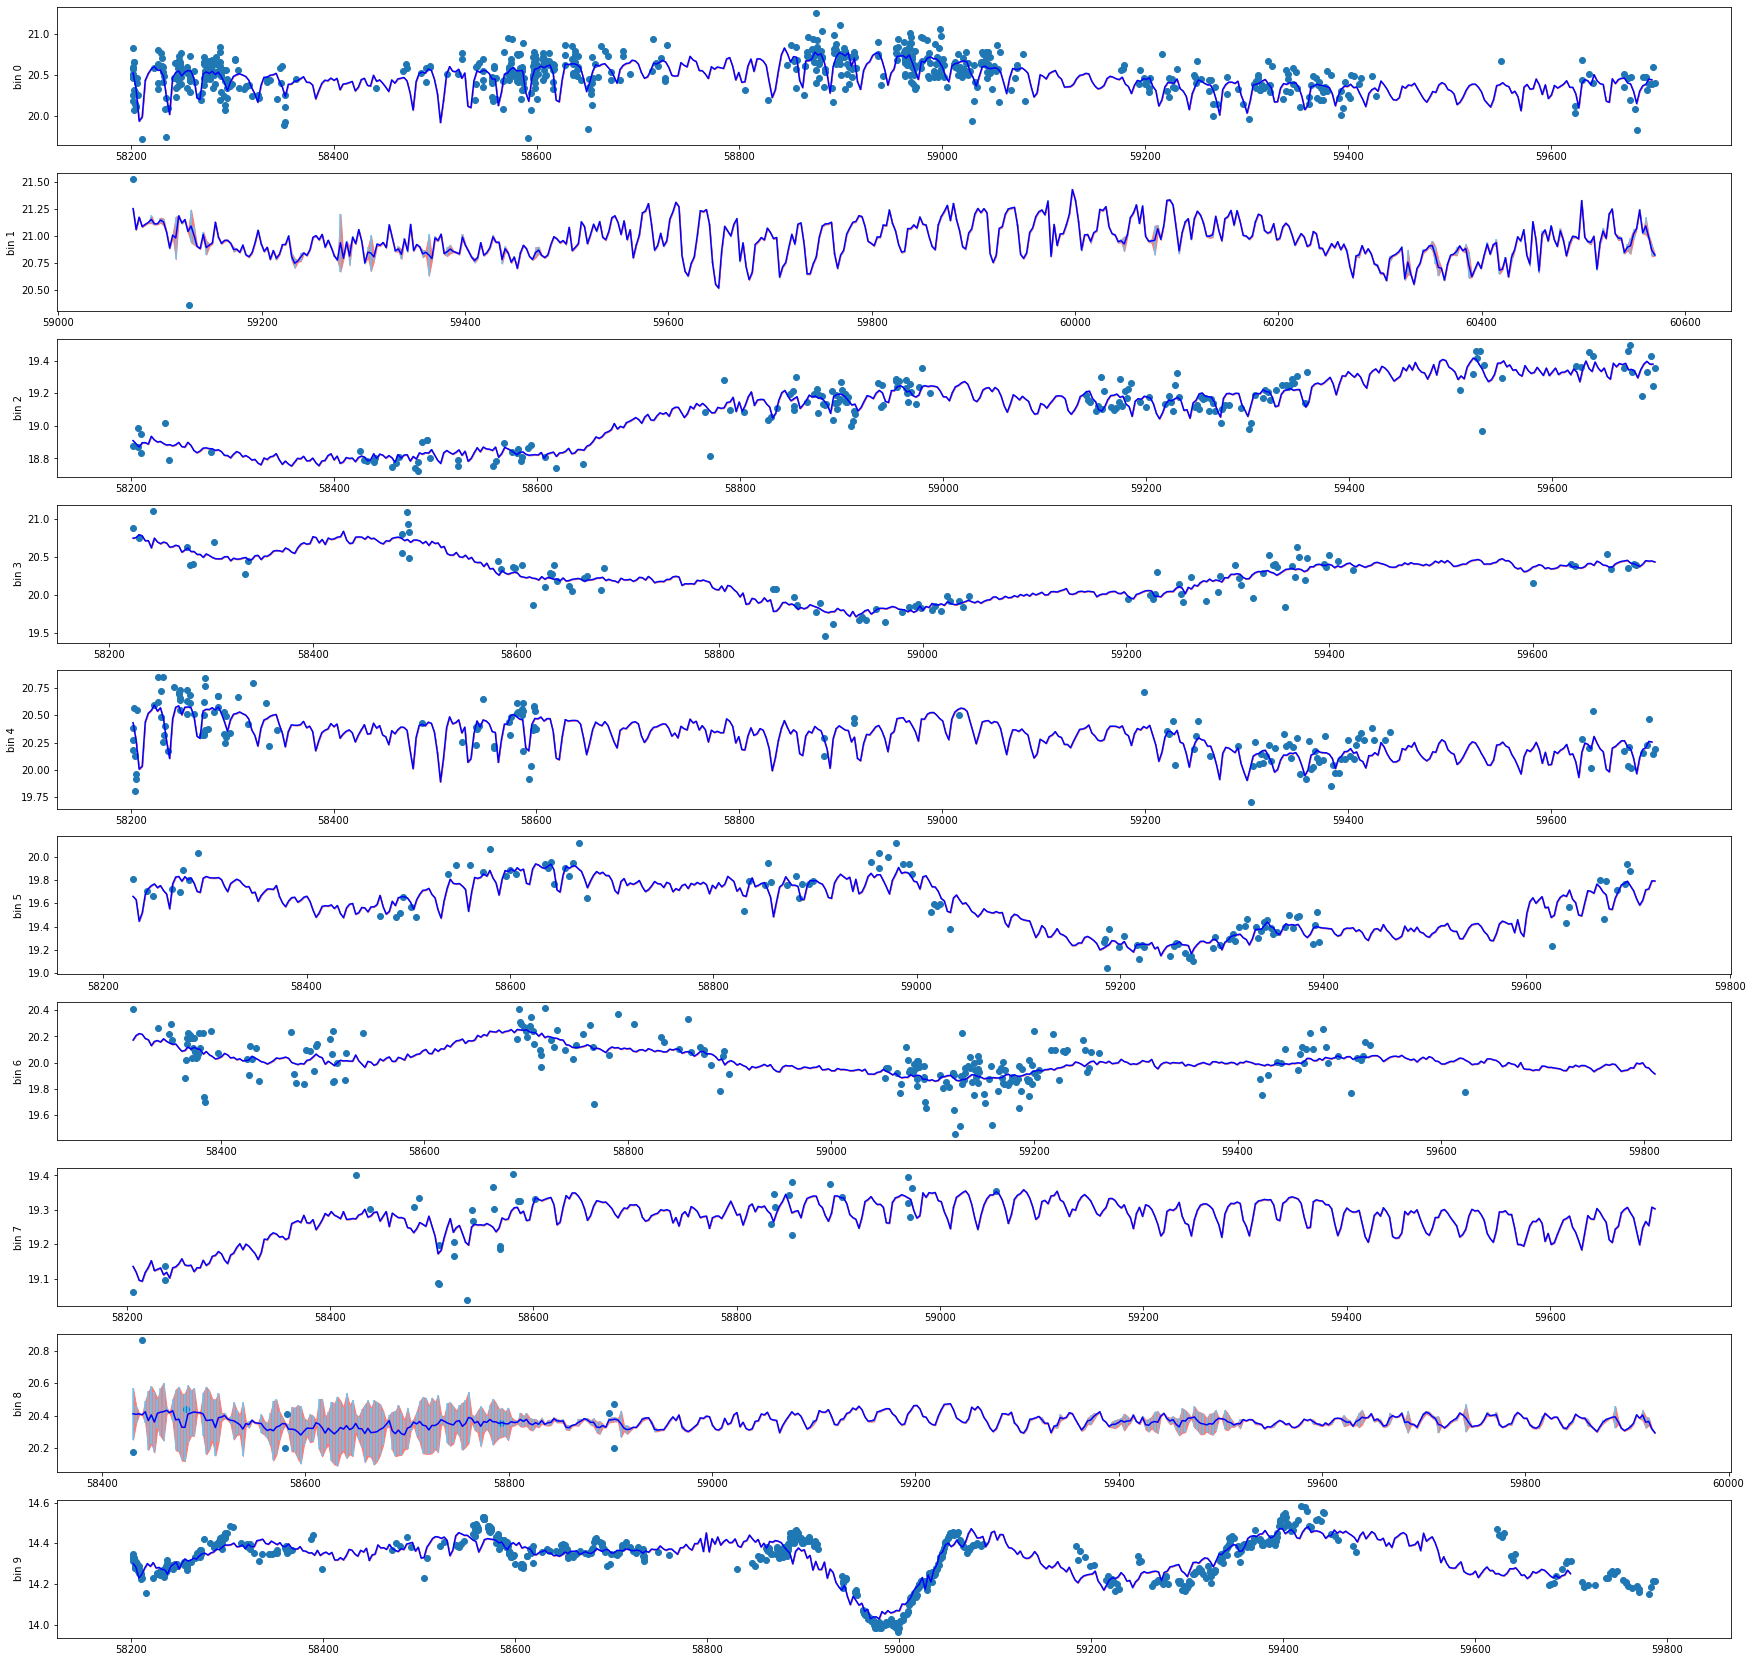

In [15]:
n=len(interps)
dims = len(lcs.bands)
figsize=(30,30)
fig,ax = plt.subplots(n,dims,figsize=figsize, squeeze=False)
for ex in range(n):
    ax[ex,0].set_ylabel(f'bin {ex}')
    for band in range(dims):
        t=intps[ex,band,:,0]
        y=intps[ex,band,:,1]
        yerr=intps[ex,band,:,2]
        ax[ex,band].fill_between(t,y-yerr,y+yerr, label='error envelope',color='lightcoral')
        ax[ex,band].errorbar(t,y,yerr=yerr, c='blue', ecolor='#65c9f7', label='prediction')
        #ax[ex,band].scatter(t,y)
        if lcs.unnormalized_data[ex][band][:,1].any(): # not missing light curves
            ax[ex,band].scatter(lcs.unnormalized_data[ex][band][:,0], lcs.unnormalized_data[ex][band][:,1])
            

In [74]:
save_folder = 'gri_interps'

if not os.path.isdir(save_folder): os.mkdir(save_folder)

obj_names = lcs.valid_files_df.index


for i in range(len(interps)):
    for j,band in enumerate(lcs.bands):
        np.savetxt(os.path.join(save_folder,f'{obj_names[i]}_{band}'), interps[i,j])